In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import shutil
import sys  
import json
import os
import spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
os.chdir('/drive/My Drive/pytorch/SQuAD')


**Install requirements**

In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 57.5 MB/s 
     |████████████████████████████████| 182 kB 50.8 MB/s 


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertModel
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Get SQuAD data and transform into data frame**

In [ ]:
input_file_train = '/drive/My Drive/pytorch/SQuAD/train-v2.0.json'
input_file_dev = '/drive/My Drive/pytorch/SQuAD/dev-v2.0.json'


In [ ]:
with open(input_file_train, "r", encoding='utf-8') as reader:
    input_data_train = json.load(reader)

with open(input_file_dev, "r", encoding='utf-8') as reader:
    input_data_dev = json.load(reader)

In [ ]:
#input_data['data'][0]['paragraphs'][0]

In [ ]:

def extract_squad_data(input_data):

  rows = []
  for group in input_data['data']:
      for passage in group['paragraphs']:
          context = passage['context']
          for qa in passage['qas']:
              question = qa['question']
              id = qa['id']
              isposible = qa['is_impossible']
              for answer in qa['answers']:
                  row_ = {'q_id':id,'Context':context,'question':question,'answer':answer,'is_impossible':isposible}
                  rows.append(row_)
  df_data = pd.DataFrame.from_dict(rows)

  return df_data



In [ ]:
df_train = extract_squad_data(input_data_train)
df_dev = extract_squad_data(input_data_dev)

In [ ]:
df_train.head()

,q_id,Context,question,answer,is_impossible
0,56be85543aeaaa14008c9063,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': 'in the late 1990s', 'answer_start': ...",False
1,56be85543aeaaa14008c9065,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': 'singing and dancing', 'answer_start'...",False
2,56be85543aeaaa14008c9066,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': '2003', 'answer_start': 526}",False
3,56bf6b0f3aeaaa14008c9601,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': 'Houston, Texas', 'answer_start': 166}",False
4,56bf6b0f3aeaaa14008c9602,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': 'late 1990s', 'answer_start': 276}",False


In [ ]:
#df_dev.head()

**Data cleaning**

In [ ]:

def extract_answer_indexs(data_df):
  # data_df = data_df[:10]
  data_df = data_df[['q_id', 'Context', 'question', 'answer','is_impossible']]
  for row in data_df.itertuples():
    ind = row[0],
    text = row[2]
    answer = row[4]
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        end_idx_ = end_idx
        start_idx_ = start_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        start_idx_ = start_idx - 1
        end_idx_ = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        start_idx_ = start_idx - 2
        end_idx_ = end_idx - 2  
    data_df.loc[ind,'answer_start'] = start_idx_
    data_df.loc[ind,'answer_end'] = end_idx_
    data_df.loc[ind,'answer_index_based'] = text[start_idx_:end_idx_]
    data_df.loc[ind,'answer_real'] = real_answer
  return data_df


In [ ]:
nlp = spacy.load("en_core_web_sm")
def get_numberof_tokens(text_):
  doc = nlp(text_)
  token_list = []
  for token in doc:
      token_list.append(token)
  return len(token_list)


In [ ]:
# df_train1 = extract_answer_indexs(df_train)

## df_train1['no_tokens'] = df_train1['Context'].apply(lambda X: get_numberof_tokens(X))
# df_train1.to_csv('df_squad_train.csv')

In [ ]:
df_test = extract_answer_indexs(df_dev)

In [ ]:
df_train = pd.read_csv("df_squad_train.csv")

In [ ]:
df_train.head()

,Unnamed: 0,q_id,Context,question,answer,is_impossible,answer_start,answer_end,answer_index_based,answer_real
0,0,56be85543aeaaa14008c9063,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': 'in the late 1990s', 'answer_start': ...",False,269.0,286.0,in the late 1990s,in the late 1990s
1,1,56be85543aeaaa14008c9065,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': 'singing and dancing', 'answer_start'...",False,207.0,226.0,singing and dancing,singing and dancing
2,2,56be85543aeaaa14008c9066,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': '2003', 'answer_start': 526}",False,526.0,530.0,2003,2003
3,3,56bf6b0f3aeaaa14008c9601,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': 'Houston, Texas', 'answer_start': 166}",False,166.0,180.0,"Houston, Texas","Houston, Texas"
4,4,56bf6b0f3aeaaa14008c9602,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': 'late 1990s', 'answer_start': 276}",False,276.0,286.0,late 1990s,late 1990s


In [ ]:
##drop instances if the answers are null. 
df_train.dropna(subset = ['answer_real'],inplace=True)

In [ ]:
df_train[df_train['answer_index_based']!=df_train['answer_real']]

,Unnamed: 0,q_id,Context,question,answer,is_impossible,answer_start,answer_end,answer_index_based,answer_real


In [ ]:

context = df_train.iloc[20]['Context']
sample_df = df_train[df_train.Context.values==context]

context

'Following the disbandment of Destiny\'s Child in June 2005, she released her second solo album, B\'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006), and starring roles in The Pink Panther (2006) and Obsessed (2009). Her marriage to rapper Jay Z and portrayal of Etta James in Cadillac Records (2008) influenced her third album, I Am... Sasha Fierce (2008), which saw the birth of her alter-ego Sasha Fierce and earned a record-setting six Grammy Awards in 2010, including Song of the Year for "Single Ladies (Put a Ring on It)". Beyoncé took a hiatus from music in 2010 and took over management of her career; her fourth album 4 (2011) was subsequently mellower in tone, exploring 1970s funk, 1980s pop, and 1990s soul. Her critically acclaimed fifth studio album, Beyoncé (2013), was distinguished from previous releases by its experimental production and exploratio

In [ ]:
sample_df = sample_df.reset_index(drop=True)

In [ ]:
for index, row in sample_df.iterrows():
  question=row['question']
  answer=row['answer']
  print('Question:{}  \t Answer: {}'.format(question,answer ))


Question:After her second solo album, what other entertainment venture did Beyonce explore?  	 Answer: {'text': 'acting', 'answer_start': 207}
Question:Which artist did Beyonce marry?  	 Answer: {'text': 'Jay Z', 'answer_start': 369}
Question:To set the record for Grammys, how many did Beyonce win?  	 Answer: {'text': 'six', 'answer_start': 565}
Question:For what movie did Beyonce receive  her first Golden Globe nomination?  	 Answer: {'text': 'Dreamgirls', 'answer_start': 260}
Question:When did Beyonce take a hiatus in her career and take control of her management?  	 Answer: {'text': '2010', 'answer_start': 586}
Question:Which album was darker in tone from her previous work?  	 Answer: {'text': 'Beyoncé', 'answer_start': 180}
Question:After what movie portraying Etta James, did Beyonce create Sasha Fierce?  	 Answer: {'text': 'Cadillac Records', 'answer_start': 406}
Question:When did Destiny's Child end their group act?  	 Answer: {'text': 'June 2005', 'answer_start': 48}
Question:Wh

In [ ]:
# df_train =df_train[df_train['no_tokens']<=512]

In [ ]:
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(df_train['Context'].to_list(), df_train['question'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(df_test['Context'].to_list(), df_test['question'].to_list(), truncation=True, padding=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
def convert_data_into_list_dict(df):
  df_dic = df.to_dict('index')
  dic_list = [df_dic[x] for x in df_dic]
  return dic_list


def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []
  count = 0
  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
      
    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length
  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
  return encodings



In [ ]:
df_train[['answer_start','answer_end']] = df_train[['answer_start','answer_end']].astype(int)
df_test[['answer_start','answer_end']] = df_test[['answer_start','answer_end']].astype(int)


In [ ]:
answers_list_train = convert_data_into_list_dict(df_train[['answer_start','answer_end']])
answers_list_test = convert_data_into_list_dict(df_test[['answer_start','answer_end']])

train_encodings = add_token_positions(train_encodings, answers_list_train)
test_encodings = add_token_positions(test_encodings, answers_list_test)

Transform data into tensors

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
test_dataset = SquadDataset(test_encodings)

Turn train and test custom Dataset's into DataLoader's

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
train_loader

**Download the pre-trained BERT model**

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
epochs = 3
# epochs = 4

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

**Finetune and evaluate the Model:**

In [ ]:
import time
total_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

 # Put model in train mode
  model.train()
    
  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader): 

    # Optimizer zero grad
    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]

    # Loss backward
    loss.backward()

    # Optimizer step (update the weights)
    optim.step()

    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ##########Model Evaluation##################

  # Set model in evaluation mode
  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(test_loader):
    
    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)
      
      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # Find the total loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(test_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(test_loader)
  val_losses.append(loss_of_epoch)

  # Print each epoch's time and train/val loss 
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - total_time))

############Train############
Batch 1000 / 5427 
Loss: 1.2 

Batch 2000 / 5427 
Loss: 1.5 

Batch 3000 / 5427 
Loss: 1.3 

Batch 4000 / 5427 
Loss: 1.5 

Batch 5000 / 5427 
Loss: 1.0 

############Evaluate############
Batch 1000 / 1269 
Loss: 1.3 


-------Epoch  1 -------
Training Loss: 1.3079337499897103 
Validation Loss: 1.0953705672488803 
Time:  8631.202411651611 
----------------------- 


############Train############
Batch 1000 / 5427 
Loss: 0.3 

Batch 2000 / 5427 
Loss: 1.0 

Batch 3000 / 5427 
Loss: 0.9 

Batch 4000 / 5427 
Loss: 1.5 

Batch 5000 / 5427 
Loss: 0.7 

############Evaluate############
Batch 1000 / 1269 
Loss: 1.3 


-------Epoch  2 -------
Training Loss: 0.7989636229281489 
Validation Loss: 1.1946273684924376 
Time:  8632.964488983154 
----------------------- 


############Train############
Batch 1000 / 5427 
Loss: 0.1 

Batch 2000 / 5427 
Loss: 0.8 

Batch 3000 / 5427 
Loss: 0.3 

Batch 4000 / 5427 
Loss: 0.4 

Batch 5000 / 5427 
Loss: 0.4 

############Evalu

In [ ]:
# Save model
torch.save(model,"/drive/My Drive/pytorch/SQuAD/finetunedmodel")

NameError: ignored

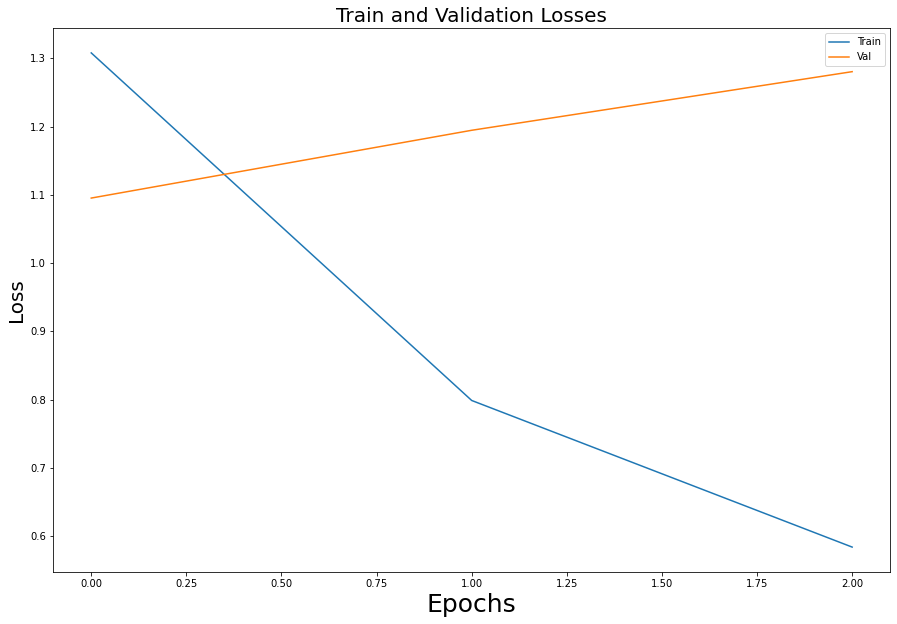

In [ ]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

**Evaluation on Single input**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# Load the fine-tuned modeol
model = torch.load("/drive/My Drive/pytorch/SQuAD/finetunedmodel",map_location=torch.device('cpu'))
model.eval()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
def predict(context,query):

  inputs = tokenizer.encode_plus(query, context, return_tensors='pt')

  outputs = model(**inputs)
  answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
  answer_end = torch.argmax(outputs[1]) + 1 

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

  return answer

def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  import string, re

  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)

  def white_space_fix(text):
    return " ".join(text.split())

  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)

  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split()
  
  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)
  
  common_tokens = set(pred_tokens) & set(truth_tokens)
  
  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0
  
  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)
  
  return 2 * (prec * rec) / (prec + rec)

In [ ]:
def give_an_answer(context,query,answer):

  prediction = predict(context,query)
  em_score = compute_exact_match(prediction, answer)
  f1_score = compute_f1(prediction, answer)

  print(f"Question: {query}")
  print(f"Prediction: {prediction}")
  print(f"True Answer: {answer}")
  print(f"EM: {em_score}")
  print(f"F1: {f1_score}")
  print("\n")

In [ ]:
context = "My name is Ramesh. I am leaving in Berlin and working as data scientist. I am 29 years old"

queries = ["Where does Ramesh live now?",
           "What Ramesh is doing?",
           "what is the age of Ramesh?"
          ]
answers = ["Berlin",
           "Data scientist",
           "29"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: Where does Ramesh live now?
Prediction: berlin
True Answer: Berlin
EM: 1
F1: 1.0


Question: What Ramesh is doing?
Prediction: working as data scientist.
True Answer: Data scientist
EM: 0
F1: 0.6666666666666666


Question: what is the age of Ramesh?
Prediction: 29
True Answer: 29
EM: 1
F1: 1.0




In [ ]:
df_test.iloc[30]

In [ ]:
df_test.iloc[30]['Context']

In [ ]:
context = 'The English name "Normans comes from the French words Normans/Normanz, plural of Normant, modern French normand, which is itself borrowed from Old Low Franconian Nortmann "Northman" or directly from Old Norse Norðmaðr, Latinized variously as Nortmannus, Normannus, or Nordmannus (recorded in Medieval Latin, 9th century) to mean Norseman, Viking'

queries = ["What is the original meaning of the word Norman?",
"From which language Normans comes from?",
          ]
answers = ['Norseman, Viking','French']

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: What is the original meaning of the word Norman?
Prediction: normand,
True Answer: Norseman, Viking
EM: 0
F1: 0


Question: From which language Normans comes from?
Prediction: old low franconian
True Answer: French
EM: 0
F1: 0


